# This notebook exemplifies the calculation of the horizontal and vertical derivatives by using the *classical equivalent layer* approach.

In [1]:
# Import all python modules
import sys
import numpy
from matplotlib import pyplot

In [2]:
sys.path.append('codes/') 

In [3]:
from codes import auxiliars, prism, sphere, grids, equivalentlayer, auxiliars, statistical, derivative

In [4]:
# Data shape:
ndata = 50
shape = (ndata, ndata)

In [5]:
# Number of observations:
xo, yo, zo = grids.regular_grid((-2000., 2000., -2000., 2000.), shape, -200.)

In [7]:
# Synthetic data produced by a vertical dike model (vertical attraction):
# (xmin, xmax, ymin, ymax, zmin, zmax, rho(km/m3) )
dike1 = (-300., 150., -100., 280., 100., 750.)
dike2 = (1000., 1350., 1400., 1680., 90., 1950.)
gz = prism.prism_gz(xo, yo, zo, dike1, 2800.0) +\
    prism.prism_gz(xo, yo, zo, dike2, 2900.0)

In [8]:
print 'Analysing gz data:'
_ = statistical.analysis(gz)

Analysing gz data:
Minimum:    86.8838
Maximum:    6316.7160
Mean value: 1101.7621
Variation:  6229.8321


In [10]:
# Adding noise
gz = auxiliars.noise_normal_dist(gz, 1., 0.1)

In [11]:
print 'Analysing noised gz data:'
_ = statistical.analysis(gz)

Analysing noised gz data:
Minimum:    87.8160
Maximum:    6317.5876
Mean value: 1102.7603
Variation:  6229.7716


#### Creating the equivalent layer:

In [12]:
# Define a mesh of masses point with unit volume:
# 1) horizontal coordinates:
area = (-2000., 2000., -2000., 2000.) # meters
shape_layer = (60, 60)
# 2) define the depth of the layer and the number of point in area:
eqlayer = equivalentlayer.layer(area, shape_layer, 700.)

In [13]:
# computing the Jacobian matrix:
A = equivalentlayer.mat_grav_gz(xo, yo, zo, eqlayer)

In [14]:
# dimensions of the sensitivity matrix of the eqlayer problem:
M = shape_layer[0] * shape_layer[1]
N = shape[0] * shape[1]
print 'Number of observations:', N
print 'Number of depth sources:', M

Number of observations: 2500
Number of depth sources: 3600


### Solve the least-square problem for the two possible cases:

In [21]:
# Estimation of vector parameters:
if N >= M: #overdetermined case
    mu = 0.0001
    I = numpy.identity(M)
    trace = numpy.trace(A.T.dot(A))/M
    vec = numpy.linalg.solve(numpy.dot(A.T, A) + mu*trace*I, numpy.dot(A.T,gz))
else:# underterminated case
    mu = 1.e-2
    I = numpy.identity(N)
    trace = numpy.trace(A.T.dot(A))/N
    aux = numpy.linalg.solve(numpy.dot(A, A.T) + mu*trace*I, gz)
    vec = numpy.dot(A.T, aux)

In [22]:
# Computing the predicted data
gz_predicted = numpy.dot(A, vec)

In [23]:
print 'Original gz_data:'
_ = statistical.analysis(gz)
print 'Predicted gz data:'
_ = statistical.analysis(gz_predicted)

Original gz_data:
Minimum:    87.8160
Maximum:    6317.5876
Mean value: 1102.7603
Variation:  6229.7716
Predicted gz data:
Minimum:    87.9431
Maximum:    5756.7695
Mean value: 1102.7457
Variation:  5668.8265


In [24]:
res, norm, mean, deviation = auxiliars.residual(gz, gz_predicted)

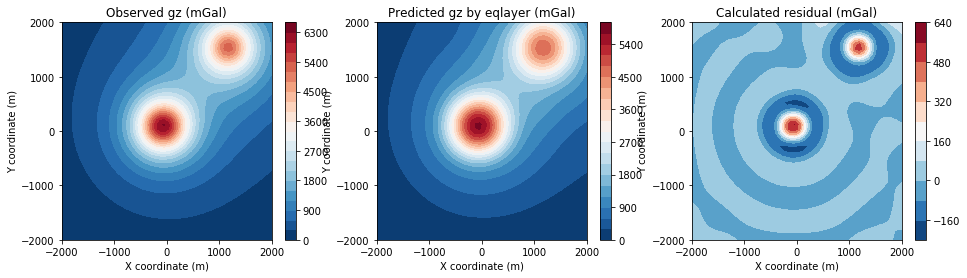

In [25]:
pyplot.figure(figsize=(16, 4))

pyplot.subplot(1, 3, 1)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gz.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Observed gz (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 2)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gz_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Predicted gz by eqlayer (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 3)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                res.reshape(ndata,ndata), 10, cmap = pyplot.cm.RdBu_r)
pyplot.title('Calculated residual (mGal)')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()

# Test for tensor elements

In [26]:
# Variation along the directinos
delta = 10.

**Calculating the numerical derivative**

In [28]:
# In X
xi = prism.prism_gz(xo - delta, yo, zo, dike1, 2800.) + prism.prism_gz(xo - delta, yo, zo, dike2, 2900.)
xf = prism.prism_gz(xo + delta, yo, zo, dike1, 2800.) + prism.prism_gz(xo + delta, yo, zo, dike2, 2900.)
diffx = (xf - xi)/(2.*delta)

In [29]:
# In Y
yi = prism.prism_gz(xo, yo - delta, zo, dike1, 2800.) + prism.prism_gz(xo, yo - delta, zo, dike2, 2900.)
yf = prism.prism_gz(xo, yo + delta, zo, dike1, 2800.) + prism.prism_gz(xo, yo + delta, zo, dike2, 2900.)
diffy = (yf - yi)/(2.*delta)

In [30]:
# In X
zi = prism.prism_gz(xo, yo, zo - 0.1*delta, dike1, 2800.) + prism.prism_gz(xo, yo, zo - 0.1*delta, dike2, 2900.)
zf = prism.prism_gz(xo, yo, zo + 0.1*delta, dike1, 2800.) + prism.prism_gz(xo, yo, zo + 0.1*delta, dike2, 2900.)
diffz = (zf - zi)/(2.*0.1*delta)

In [31]:
gzx, gzy, gzz = equivalentlayer.mat_grav_gz_xyz(xo, yo, zo, eqlayer)

In [33]:
# Computing the tensor elements
gzx_predicted = numpy.dot(gzx, vec)
gzy_predicted = numpy.dot(gzy, vec)
gzz_predicted = numpy.dot(gzz, vec)

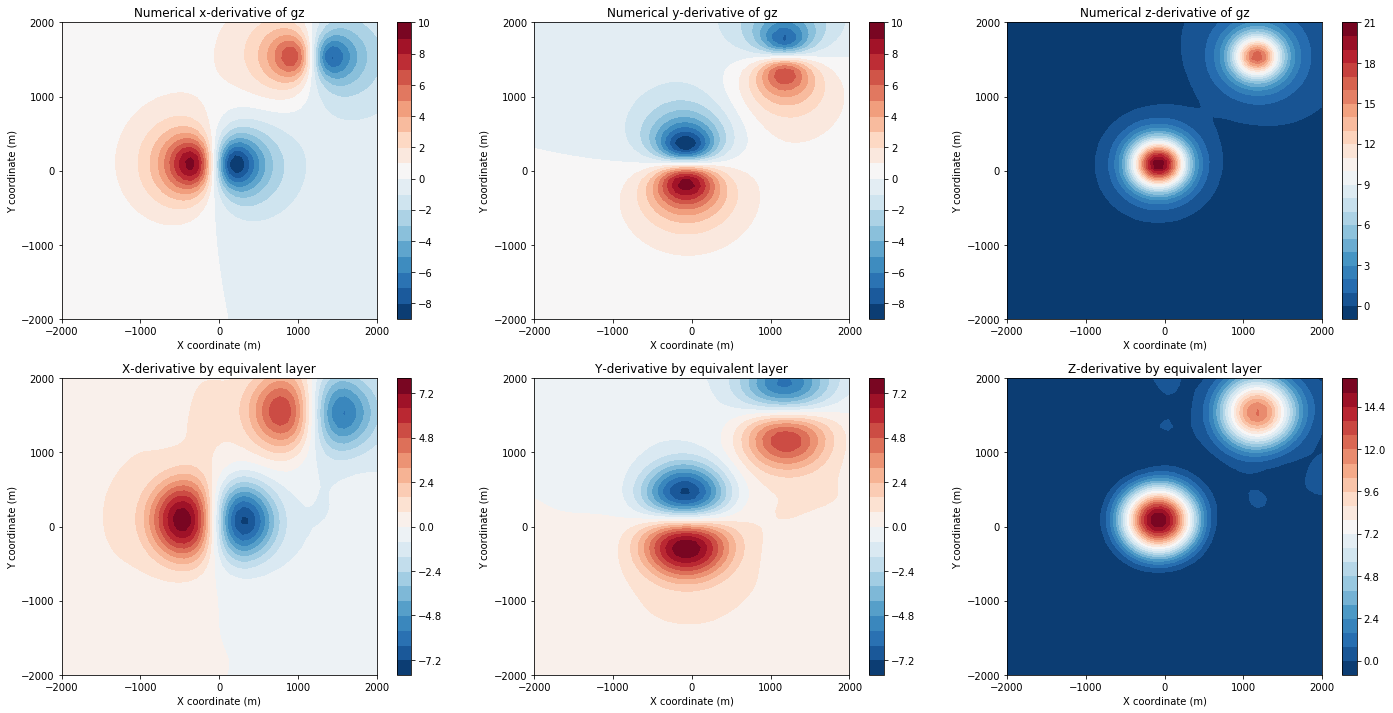

In [35]:
pyplot.figure(figsize=(24, 12))

pyplot.subplot(2, 3, 1)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffx.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Numerical x-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 2)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffy.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Numerical y-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 3)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                diffz.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Numerical z-derivative of gz')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 4)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzx_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('X-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 5)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzy_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Y-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(2, 3, 6)
pyplot.contourf(xo.reshape(ndata,ndata), yo.reshape(ndata,ndata), 
                gzz_predicted.reshape(ndata,ndata), 20, cmap = pyplot.cm.RdBu_r)
pyplot.title('Z-derivative by equivalent layer')
pyplot.xlabel('X coordinate (m)')
pyplot.ylabel('Y coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()